In [2]:
import os
import re
import glob
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import shapely

import clima_anom as ca

import matplotlib.cbook
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

In [65]:
with open ('../../json/directories.json') as f:
    DIRS = json.load(f)

In [94]:
andes = list(shpreader.Reader(DIRS['mapping']+'andes_1000.shp').geometries())
commu = list(shpreader.Reader('/mnt/Data/Github/Complex-Network-AS/mapping/communities/Comm_IMERG_05x05_sync_summer_P90_tau3_SP95.shp').geometries())

In [6]:
#Using IMERG 05x05 grid
file_in = DIRS['dir_IMERG'] + 'IMERG_2000_12_2020_12_24h_05x05_summer.nc'

data = ca.read_netcdf(file_in,0)
lat = data['lat'].data
lon = data['lon'].data

lon2d, lat2d = np.meshgrid(lon, lat)

nlat = len(lat)
nlon = len(lon)

res_y = lat[1]-lat[0]
res_x = lon[1]-lon[0]

del data

print(f'Latitude points   : {nlat}')
print(f'Longitude points  : {nlon}')
print(f'Spatial resolution: {res_x}x{res_y}')

Latitude points   : 120
Longitude points  : 110
Spatial resolution: 0.5x0.5


In [7]:
xmin, ymin, xmax, ymax= np.min(lon2d)-0.25,np.min(lat2d)+0.25,np.max(lon2d)-0.25,np.max(lat2d)+0.25

# how many cells across and down
cell_size_y=0.5
cell_size_x=0.5

# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size_x, cell_size_x ):
    for y0 in np.arange(ymin, ymax+cell_size_y, cell_size_y):
        # bounds
        x1 = x0+cell_size_x
        y1 = y0-cell_size_y
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs="EPSG:4326")
cell = cell.reset_index()

In [8]:
product = 'ENSEMBLE'

In [19]:
file_list = pd.read_csv(DIRS['dir_ENSEMBLE_list']+'TRMM_GPM_summer_200012_2021_02.csv')
len_files = len(file_list)
print(f'Files Number: {len_files}')
print(file_list['file_name'].iloc[0])
print(file_list['file_name'].iloc[-1])

Files Number: 63
/mnt/Data/Data/PF/TRMM/rpf_SA/rpf_200012_level2.csv
/mnt/Data/Data/PF/GPM/rgpf_SA/rgpf_202102_level2.csv


In [83]:
# Show columns
data_tmp = pd.read_csv(file_list['file_name'].iloc[0])
data_tmp.columns

Index(['lat', 'lon', 'YEAR', 'ORBIT', 'NPIXELS_20DBZ', 'NPIXELS_30DBZ',
       'NPIXELS_40DBZ', 'NPIXELS_50DBZ', 'NPIXELS_20MM', 'NPIXELS_30MM',
       'NPIXELS_40MM', 'NPIXELS_50MM', 'VOLRAIN_20DBZ', 'VOLRAIN_30DBZ',
       'VOLRAIN_40DBZ', 'VOLRAIN_50DBZ', 'VOLRAIN_20MM', 'VOLRAIN_30MM',
       'VOLRAIN_40MM', 'VOLRAIN_50MM', 'MIN85PCT', 'MIN37PCT', 'NLT250',
       'NLT225', 'N37LT250', 'N37LT225', 'MAXHT20', 'MAXHT30', 'MAXHT40',
       'NSTRAT_2A25', 'RAINSTRAT_2A25', 'NCONV_2A25', 'RAINCONV_2A25'],
      dtype='object')

In [142]:
# var = 'NPIXELS_20DBZ'
# val_min = 1
# var_name = '20dbz_pixels_GT_'+str(val_min)
# long_name = 'Number of pixel with 20dbz'

# var = 'NPIXELS_30DBZ'
# val_min = 1
# var_name = '30dbz_pixels_GT_'+str(val_min)
# long_name = 'Number of pixel with 30dbz'

# var = 'NPIXELS_40DBZ'
# val_min = 1
# var_name = '40dbz_pixels_GT_'+str(val_min)
# long_name = 'Number of pixel with 40dbz'

# var = 'NPIXELS_50DBZ'
# val_min = 1
# var_name = '50dbz_pixels_GT_'+str(val_min)
# long_name = 'Number of pixel with 50dbz'

# var = 'MAXHT20'
# var_name = 'MAXHT20_GT_10km'
# val_min = 10
# long_name = 'Maximum height with 20 dBZ echo (km)'

# var = 'MAXHT30'
# var_name = 'MAXHT30_GT_10km'
# val_min = 0
# long_name = 'Maximum height with 30 dBZ echo (km)'

var = 'MAXHT40'
var_name = 'MAXHT40_GT_10km'
val_min = 0
long_name = 'Maximum height with 40 dBZ echo (km)'

# var = 'NPIXELS_20MM'
# var_name = 'NPIXELS_GT_20MM'
# val_min = 0

# var = 'NPIXELS_30MM'
# var_name = 'NPIXELS_GT_30MM'
# val_min = 0

# var = 'NCONV_KU'
# var_name = 'NCONV'
# val_min = 0

# var = 'MIN85PCT'
# var_name = 'MIN85PCT_LT_225K'
# val_min = 225

In [183]:
# https://pygis.io/docs/e_summarize_vector.html
pf_count = np.ones([len_files,nlat,nlon])*np.nan

for t in range(len_files):

    file_in = file_list['file_name'][t]
    name_out = file_in.split('/')[-1]
    print(name_out)

    data = pd.read_csv(file_in)
    data_cut = data[data[var] != val_min].reset_index(drop=True)

    PF_GPD = gpd.GeoDataFrame(geometry=gpd.points_from_xy(data_cut['lon'],data_cut['lat'], crs="EPSG:4326"))

    wells_cell = gpd.sjoin(PF_GPD, cell, how = "inner", predicate = "intersects")
    wells_cell = wells_cell.drop_duplicates(subset = ['index']).reset_index(drop = True)
    count_field = "Count"
    wells_cell[count_field] = 1
    wells_cell = wells_cell.groupby('index').agg({count_field:'sum'}) #for pixel
    bay_area_grid = cell.merge(wells_cell, on = 'index', how = "left")
    bay_area_grid[count_field] = bay_area_grid[count_field].fillna(0)
    bay_area_grid[count_field] = bay_area_grid[count_field].astype(int)

    data_out = bay_area_grid['Count'].values.reshape(nlon, nlat).T

    pf_count[t,:,:] = data_out 

rpf_200012_level2.csv
rpf_200101_level2.csv
rpf_200102_level2.csv
rpf_200112_level2.csv
rpf_200201_level2.csv
rpf_200202_level2.csv
rpf_200212_level2.csv
rpf_200301_level2.csv
rpf_200302_level2.csv
rpf_200312_level2.csv
rpf_200401_level2.csv
rpf_200402_level2.csv
rpf_200412_level2.csv
rpf_200501_level2.csv
rpf_200502_level2.csv
rpf_200512_level2.csv
rpf_200601_level2.csv
rpf_200602_level2.csv
rpf_200612_level2.csv
rpf_200701_level2.csv
rpf_200702_level2.csv
rpf_200712_level2.csv
rpf_200801_level2.csv
rpf_200802_level2.csv
rpf_200812_level2.csv
rpf_200901_level2.csv
rpf_200902_level2.csv
rpf_200912_level2.csv
rpf_201001_level2.csv
rpf_201002_level2.csv
rpf_201012_level2.csv
rpf_201101_level2.csv
rpf_201102_level2.csv
rpf_201112_level2.csv
rpf_201201_level2.csv
rpf_201202_level2.csv
rpf_201212_level2.csv
rpf_201301_level2.csv
rpf_201302_level2.csv
rpf_201312_level2.csv
rpf_201401_level2.csv
rpf_201402_level2.csv
rgpf_201412_level2.csv
rgpf_201501_level2.csv
rgpf_201502_level2.csv
rgpf_20

In [177]:
print(f'pf count shape: {pf_count.shape}')
nameout = DIRS['dir_ENSEMBLE'] + product+'_SA_count_'+var_name+'.nc'
info = {'file': nameout,
        'title': 'Number of events to '+ product +' for '+ var_name +' for IMERG grid 0.5x0.5',
        'year_start':2014,'month_start':3,'day_start':1,'hour_start':0,'minute_start':0,
        'year_end':2021,'month_end':3,'day_end':1,'hour_end':23,'minute_end':59,
        'time_frequency': 'Monthly',
        'time_interval':1,
        'var_name': 'count',
        'var_units': 'adim'}
print(info['file'])

pf count shape: (63, 120, 110)
/mnt/Data/Data/PF/ENSEMBLE/ENSEMBLE_SA/ENSEMBLE_SA_count_MAXHT40_GT_10km.nc


In [178]:
ca.create_netcdf(info,pf_count,lat,lon)

Time Start: 2014-03-01 00:00:00
Time End: 2021-03-01 00:00:00
Time Frequency: Monthly
Time Lenght: 85

File created in:  /mnt/Data/Data/PF/ENSEMBLE/ENSEMBLE_SA/ENSEMBLE_SA_count_MAXHT40_GT_10km.nc
File title:  Number of events to ENSEMBLE for MAXHT40_GT_10km for IMERG grid 0.5x0.5
var title:  count
var units:  adim


In [179]:
tmp_mean = np.nansum(pf_count,axis=0)
# tmp_mean = np.nanmean(pf_count,axis=0)
tmp_mean[tmp_mean==0] = np.nan

In [181]:
tmp = np.zeros_like(tmp_mean)
for i in range(nlat):
    for j in range(nlon):
        serie = pf_count[:,i,j]
        tmp[i,j] = np.nansum(serie[serie!=0])
        if tmp[i,j] > 2:
            print(i,j,tmp[i,j])

0 21 4.0
0 23 3.0
0 56 3.0
1 55 3.0
1 61 3.0
1 64 3.0
1 72 4.0
1 73 4.0
1 76 3.0
1 78 4.0
1 84 3.0
1 102 4.0
2 11 4.0
2 21 4.0
2 24 3.0
2 38 3.0
2 70 3.0
2 75 6.0
2 82 3.0
2 94 3.0
2 102 3.0
3 9 3.0
3 24 4.0
3 61 3.0
3 64 3.0
3 68 3.0
3 69 4.0
3 71 3.0
4 13 3.0
4 22 3.0
4 53 3.0
4 62 3.0
4 68 3.0
4 69 3.0
4 72 3.0
4 78 3.0
4 79 3.0
4 86 3.0
4 95 3.0
4 102 4.0
5 67 3.0
5 77 3.0
5 86 3.0
6 49 3.0
6 61 4.0
6 63 3.0
6 77 3.0
6 81 3.0
6 89 6.0
6 104 3.0
7 24 3.0
7 46 3.0
7 49 3.0
7 55 3.0
7 76 3.0
7 80 3.0
8 7 3.0
8 10 4.0
8 54 3.0
8 69 3.0
8 73 4.0
8 76 3.0
8 81 4.0
8 87 3.0
8 96 3.0
8 107 3.0
9 30 3.0
9 42 3.0
9 43 3.0
9 79 3.0
9 95 3.0
10 56 3.0
10 74 4.0
11 7 3.0
11 38 3.0
11 42 3.0
11 55 3.0
11 77 3.0
11 81 4.0
11 94 3.0
11 96 3.0
12 16 3.0
12 42 3.0
12 43 3.0
12 46 3.0
12 63 3.0
12 72 3.0
12 74 3.0
12 76 3.0
12 81 3.0
12 89 3.0
12 98 4.0
12 107 3.0
13 31 3.0
13 36 4.0
13 41 4.0
13 50 3.0
13 68 3.0
13 75 3.0
13 83 4.0
13 89 3.0
13 93 3.0
13 96 3.0
14 47 3.0
14 49 4.0
14 51 3.0
14 54 3.

../../images/ENSEMBLE/ENSEMBLE_MAXHT40_GT_10km.png


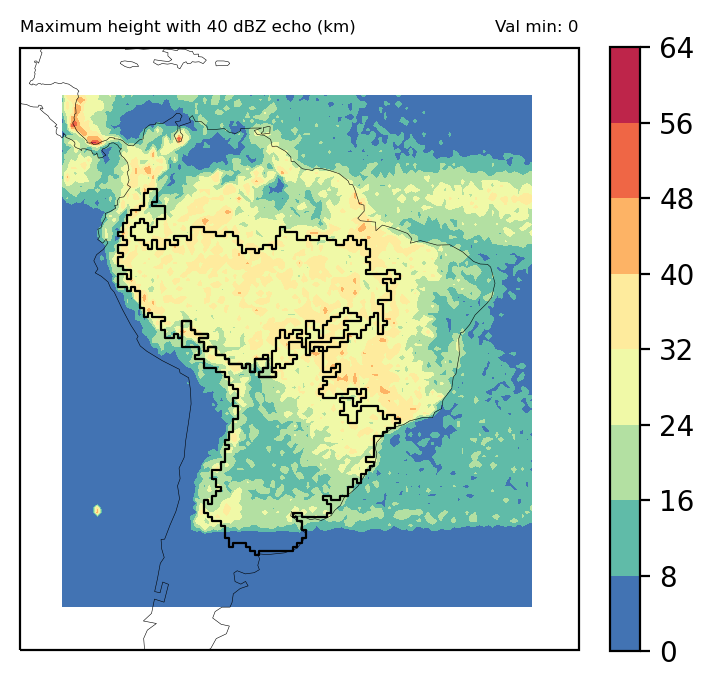

In [182]:
proj = ccrs.PlateCarree()
cmap = plt.cm.Spectral_r

levels = None

fig = plt.figure(figsize=(4,4),dpi=200)
gs = gridspec.GridSpec(1,1)

ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.coastlines(linestyle='-',linewidth=0.2,color='black',zorder=4)
ax1.set_extent([-90,-25,-50,20],crs=proj)
# ax1.add_geometries(andes,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.15,zorder=5)
ax1.add_geometries(commu,proj,edgecolor='k',facecolor='None',linestyle='-',linewidth=0.8,zorder=5)

# a1 = ax1.contourf(lon2d, lat2d, tmp_mean, cmap=cmap)
a1 = ax1.contourf(lon2d, lat2d, tmp, cmap=cmap)

ax1.set_title(long_name,fontsize=6,loc='left')
ax1.set_title('Val min: '+str(val_min),fontsize=6,loc='right')
plt.colorbar(a1,fraction=0.049)

salida = DIRS['dir_images'] + product + '/' + 'ENSEMBLE_' + var_name + '.png'
print(salida)
# plt.savefig(salida,transparent = False,bbox_inches ='tight',pad_inches = 0.05, facecolor='white')